# Imports from figures.py

In [16]:
from __future__ import division, print_function
from io import StringIO
from nowcast.figures import figures
from glob import glob
import os
from datetime import datetime, timedelta
import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
import numpy as np
import scipy.io as sio

from salishsea_tools import (
    viz_tools,
    nc_tools,
    tidetools, geo_tools
)


# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13'}

mpl.rcParams.update({'font.size': 14})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

SyntaxError: only named arguments may follow *expression (shared.py, line 155)

In [2]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [3]:
run_date = datetime.datetime(2014,10,8)
# Results dataset location
results_home = '/ocean/jieliu/research/meopar/surface current/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [4]:
def date(year, month, day_start, day_end, period, grid):
    
    day_range = np.arange(day_start, day_end+1)
    day_len = len(day_range)
    files_all = [None] * day_len
    inds = np.arange(day_len)
    
    for i, day in zip(inds, day_range):
        run_date = datetime.datetime(year,month, day)
        results_home = '/ocean/jieliu/research/meopar/surface current/'
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        filename = 'SalishSea_' + period + '_' + run_date.strftime('%Y%m%d').lower() + \
        '_' + run_date.strftime('%Y%m%d').lower() + '_' + grid + '.nc'
        file_single = os.path.join(results_dir, filename)
        files_all[i] = file_single

    return files_all

In [5]:
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 

In [6]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']

In [7]:
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 1
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

In [8]:
bathyy,X,Y = tidetools.get_SS2_bathy_data()

## Prepare salinity data

In [9]:
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141007.mat')  

In [10]:
def find_dist (q, lon11, lat11, X, Y, bathy, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd):
    k=0
    values =0
    valuess=0
    dist = np.zeros(9)
    weights = np.zeros(9)
    value_3rd=np.zeros(9)
    value_4rd=np.zeros(9)
    
    x1, j1 = geo_tools.find_closest_model_point(lon11[q],lat11[q],X,Y,land_mask=bathy.mask)
    for i in np.arange(x1-1,x1+2):
        for j in np.arange(j1-1,j1+2):
            dist[k]=geo_tools.haversine(lon11[q],lat11[q],longitude[i,j],latitude[i,j])
            weights[k]=1.0/dist[k]
            value_3rd[k]=saline_nemo_3rd[i,j]*weights[k]
            value_4rd[k]=saline_nemo_4rd[i,j]*weights[k]
            values=values+value_3rd[k]
            valuess=valuess+value_4rd[k]
            k+=1
            
    return values, valuess, weights

In [11]:
def salinity_fxn(saline):

    a=saline['ferryData']
    b=a['data']
    dataa = b[0,0]
    time=dataa['matlabtime'][0,0]
    lonn=dataa['Longitude'][0,0]
    latt=dataa['Latitude'][0,0]
    salinity=dataa['Practical_Salinity'][0,0]
    
    
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])
    run_lower = run_date.replace(hour = 3, minute = 0)#!!more convenient than day,miniute..
    run_upper = run_date.replace(hour= 5, minute =15)
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        
        if (python_datetime >= run_lower) &(python_datetime <= run_upper):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]
            
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    lon11=lon1_2_4[0:-1:20]
    lat11=lat1_2_4[0:-1:20]
    salinity11=salinity1_2_4[0:-1:20]
    
    bathy, X, Y = tidetools.get_SS2_bathy_data()
    
    aa=date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 
    
    date_str = run_date.strftime('%d-%b-%Y') ##creat a string based on this date
    tracers=nc.Dataset(aa[0])
    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']
    saline_nemo_3rd = saline_nemo[3,1, 0:898, 0:398] 
    saline_nemo_4rd = saline_nemo[4,1, 0:898, 0:398]
    
    matrix=np.zeros([len(lon11),9])
    values=np.zeros([len(lon11),1])
    valuess=np.zeros([len(lon11),1])
    value_mean_3rd_hour=np.zeros([len(lon11),1])
    value_mean_4rd_hour=np.zeros([len(lon11),1]) 
    for q in np.arange(0,len(lon11)):
       values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                     bathy, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd)
       value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
       value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])

    return lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_3rd_hour, value_mean_4rd_hour,\
    salinity11, salinity1_2_4,date_str

In [12]:
# Hides Deprecation warming - needs fixing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [13]:
# Dictionary of ferry stations - new
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Duke': {'lat': 49.1632,'lon': -123.8909},
                  'Vancouver': {'lat': 49.2827,'lon': -123.1207}}

In [14]:
def salinity_ferry_route(grid_T, grid_B, PNW_coastline, ferry_sal):
    """ plot daily salinity comparisons between ferry observations 
    and model results as well as ferry route with model salinity 
    distribution.
    
    :arg grid_B: Bathymetry dataset for the Salish Sea NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg PNW_coastline: Coastline dataset.
    :type PNW_coastline: :class:`mat.Dataset`
    
    :arg ferry_sal: saline
    :type ferry_sal: numpy
    
    :returns: fig
    """

    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    #figures.plot_map(axs[1], PNW_coastline)
    viz_tools.plot_coastline(axs[1],bathy,coords='map')
    axs[1].set_xlim(-124.5, -122.5)
    axs[1].set_ylim(48.2, 49.5)
    viz_tools.set_aspect(axs[1],coords='map',lats=latitude)
    cmap=plt.get_cmap('spectral')
    cmap.set_bad('burlywood')
    mesh=axs[1].pcolormesh(longitude[:],latitude[:],sal_hr[:],cmap=cmap)
    cbar=fig.colorbar(mesh)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('Practical Salinity', color='white')
    axs[1].set_axis_bgcolor('burlywood')
    
    axs[1].set_title('Ferry Route: 3am[UTC] 1.5m model result ', **title_font)
 
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)
    stations=['Tsawwassen','Duke','Vancouver']
    for stn in stations:
        axs[1].plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='white',\
                 markersize=10, markeredgewidth=2)
    axs[1].annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon'] + 0.02,\
    ferry_stations['Tsawwassen']['lat'] + 0.12), fontsize=15, color='black', bbox=bbox_args )
    axs[1].annotate ('Duke Point',(ferry_stations['Duke']['lon'] - 0.35,\
    ferry_stations['Duke']['lat'] -0.1),fontsize=15, color='black', bbox=bbox_args )
    axs[1].annotate ('Vancouver',(ferry_stations['Vancouver']['lon'] - 0.1,\
    ferry_stations['Vancouver']['lat']+ 0.09 ),fontsize=15, color='black', bbox=bbox_args )
    figures.figures.axis_colors(axs[1], 'white') 
    
    
    lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_3rd_hour, value_mean_4rd_hour,\
    salinity11,salinity1_2_4, date_str = salinity_fxn(saline)
    axs[1].plot(lon11,lat11,'black', linewidth = 4)
    model_salinity_3rd_hour=axs[0].plot(lon11,value_mean_3rd_hour,'DodgerBlue',\
                                    linewidth=2, label='3 am [UTC]')
    model_salinity_4rd_hour=axs[0].plot(lon11,value_mean_4rd_hour,'MediumBlue',\
                                        linewidth=2, label="4 am [UTC]" )
    observation_salinity=axs[0].plot(lon1_2_4,salinity1_2_4,'DarkGreen', linewidth=2, label="Observed")
    axs[0].text(0.25, -0.1,'Observations from Ocean Networks Canada', \
                transform=axs[0].transAxes, color='white')

    axs[0].set_xlim(-124, -123)
    axs[0].set_ylim(10, 32)
    axs[0].set_title('1.5m Salinity: ' + date_str, **title_font)
    axs[0].set_xlabel('Longitude', **axis_font)
    axs[0].set_ylabel('Practical Salinity', **axis_font)
    axs[0].legend(loc = 3)
    axs[0].grid()
   

    fig.patch.set_facecolor('#2B3E50')
    figures.figures.axis_colors(axs[1], 'gray') 
    
    return fig


# Plot

AttributeError: 'module' object has no attribute 'figures'

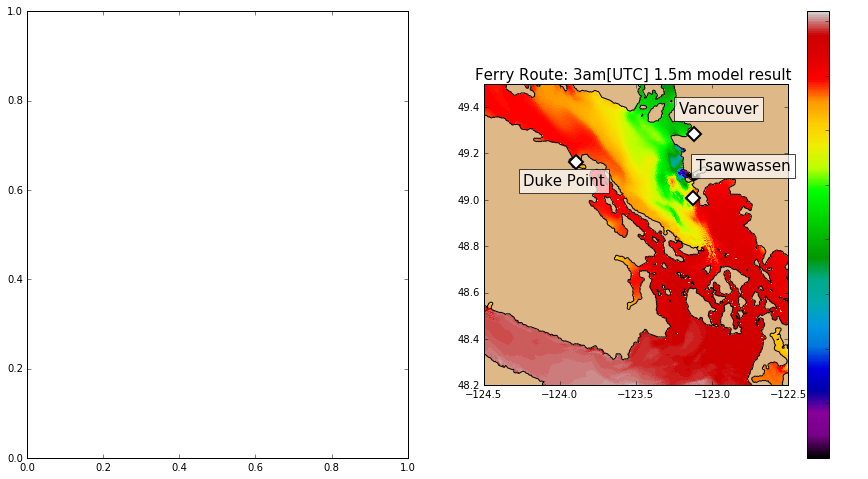

In [15]:
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, saline)